## Facies classification using an SVM classifier with RBF kernel


#### Contest entry by: <a href="https://github.com/mycarta">Matteo Niccoli</a> and <a href="https://github.com/dahlmb">Mark Dahl</a>

####  [Original contest notebook](https://github.com/seg/2016-ml-contest/blob/master/Facies_classification.ipynb) by Brendon Hall, [Enthought](https://www.enthought.com/)



<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">The code and ideas in this notebook,</span> by <span xmlns:cc="http://creativecommons.org/ns#" property="cc:attributionName">Matteo Niccoli and Mark Dahl,</span> are licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.

In this notebook we will train a machine learning algorithm to predict facies from well log data.  The dataset comes from a class exercise from The University of Kansas on [Neural Networks and Fuzzy Systems](http://www.people.ku.edu/~gbohling/EECS833/).  This exercise is based on a consortium project to use machine learning techniques to create a reservoir model of the largest gas fields in North America, the Hugoton and Panoma Fields. For more info on the origin of the data, see [Bohling and Dubois (2003)](http://www.kgs.ku.edu/PRS/publication/2003/ofr2003-50.pdf) and [Dubois et al. (2007)](http://dx.doi.org/10.1016/j.cageo.2006.08.011). 

The dataset consists of log data from nine wells that have been labeled with a facies type based on observation of core. We will use this log data to train a support vector machine to classify facies types. 

### The plan

After a quick exploration of the dataset, we will:
- run cross-validated grid search (with stratified k-fold) for parameter tuning
- look at validation curves of RMS error versus regularization parameter to ensure we are not over fitting
- train a new classifier with tuned parameters using leave-one-well-out as a method of testing


### Exploring the dataset

First, we will examine the data set we will use to train the classifier.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn import preprocessing
from sklearn.metrics import f1_score, accuracy_score, make_scorer

from sklearn.model_selection import LeaveOneGroupOut, validation_curve
import pandas as pd
from pandas import set_option
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

In [2]:
filename = 'facies_vectors.csv'
training_data = pd.read_csv(filename)
training_data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...,...,...,...,...
4144,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685
4145,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677
4146,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669
4147,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661


This data is from the Council Grove gas reservoir in Southwest Kansas.  The Panoma Council Grove Field is predominantly a carbonate gas reservoir encompassing 2700 square miles in Southwestern Kansas.  This dataset is from nine wells (with 4149 examples), consisting of a set of seven predictor variables and a rock facies (class) for each example vector and validation (test) data (830 examples from two wells) having the same seven predictor variables in the feature vector.  Facies are based on examination of cores from nine wells taken vertically at half-foot intervals. Predictor variables include five from wireline log measurements and two geologic constraining variables that are derived from geologic knowledge. These are essentially continuous variables sampled at a half-foot sample rate. 

The seven predictor variables are:
* Five wire line log curves include [gamma ray](http://petrowiki.org/Gamma_ray_logs) (GR), [resistivity logging](http://petrowiki.org/Resistivity_and_spontaneous_%28SP%29_logging) (ILD_log10),
[photoelectric effect](http://www.glossary.oilfield.slb.com/en/Terms/p/photoelectric_effect.aspx) (PE), [neutron-density porosity difference and average neutron-density porosity](http://petrowiki.org/Neutron_porosity_logs) (DeltaPHI and PHIND). Note, some wells do not have PE.
* Two geologic constraining variables: nonmarine-marine indicator (NM_M) and relative position (RELPOS)

The nine discrete facies (classes of rocks) are: 
1. Nonmarine sandstone
2. Nonmarine coarse siltstone 
3. Nonmarine fine siltstone 
4. Marine siltstone and shale 
5. Mudstone (limestone)
6. Wackestone (limestone)
7. Dolomite
8. Packstone-grainstone (limestone)
9. Phylloid-algal bafflestone (limestone)

These facies aren't discrete, and gradually blend into one another. Some have neighboring facies that are rather close.  Mislabeling within these neighboring facies can be expected to occur.  The following table lists the facies, their abbreviated labels and their approximate neighbors.

Facies |Label| Adjacent Facies
:---: | :---: |:--:
1 |SS| 2
2 |CSiS| 1,3
3 |FSiS| 2
4 |SiSh| 5
5 |MS| 4,6
6 |WS| 5,7
7 |D| 6,8
8 |PS| 6,7,9
9 |BS| 7,8

Let's clean up this dataset.  The 'Well Name' and 'Formation' columns can be turned into a categorical data type.  

In [3]:
training_data['Well Name'] = training_data['Well Name'].astype('category')
training_data['Formation'] = training_data['Formation'].astype('category')
training_data['Well Name'].unique()

[SHRIMPLIN, ALEXANDER D, SHANKLE, LUKE G U, KIMZEY A, CROSS H CATTLE, NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]
Categories (10, object): [SHRIMPLIN, ALEXANDER D, SHANKLE, LUKE G U, ..., NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]

These are the names of the 10 training wells in the Council Grove reservoir.  Data has been recruited into pseudo-well 'Recruit F9' to better represent facies 9, the Phylloid-algal bafflestone. 

Before we plot the well data, let's define a color map so the facies are represented by consistent color in all the plots in this tutorial.  We also create the abbreviated facies labels, and add those to the `facies_vectors` dataframe.

In [4]:
# 1=sandstone  2=c_siltstone   3=f_siltstone # 4=marine_silt_shale 
#5=mudstone 6=wackestone 7=dolomite 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041', '#DC7633','#A569BD',
       '#000000', '#000080', '#2E86C1', '#AED6F1', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
training_data.loc[:,'FaciesLabels'] = training_data.apply(lambda row: label_facies(row, facies_labels), axis=1)
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,3232.000000,4149.000000,4149.000000
mean,4.503254,2906.867438,64.933985,0.659566,4.402484,13.201066,3.725014,1.518438,0.521852
std,2.474324,133.300164,30.302530,0.252703,5.274947,7.132846,0.896152,0.499720,0.286644
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2821.500000,44.730000,0.498000,1.600000,8.500000,3.100000,1.000000,0.277000
50%,4.000000,2932.500000,64.990000,0.639000,4.300000,12.020000,3.551500,2.000000,0.528000
75%,6.000000,3007.000000,79.438000,0.822000,7.500000,16.050000,4.300000,2.000000,0.769000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


This is a quick view of the statistical distribution of the input variables.  Looking at the `count` values, most values have 4149 valid values except for `PE`, which has 3232.  We will drop the feature vectors that don't have a valid `PE` entry.

In [5]:
PE_mask = training_data['PE'].notnull().values
training_data = training_data[PE_mask]

In [6]:
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000
mean,4.422030,2875.824567,66.135769,0.642719,3.559642,13.483213,3.725014,1.498453,0.520287
std,2.504243,131.006274,30.854826,0.241845,5.228948,7.698980,0.896152,0.500075,0.286792
min,1.000000,2573.500000,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,2.000000,2791.000000,46.918750,0.492750,1.163750,8.346750,3.100000,1.000000,0.273000
50%,4.000000,2893.500000,65.721500,0.624437,3.500000,12.150000,3.551500,1.000000,0.526000
75%,6.000000,2980.000000,79.626250,0.812735,6.432500,16.453750,4.300000,2.000000,0.767250
max,9.000000,3122.500000,361.150000,1.480000,18.600000,84.400000,8.094000,2.000000,1.000000


Now we extract just the feature variables we need to perform the classification.  The predictor variables are the five log values and two geologic constraining variables, **and we are also using depth**. We also get a vector of the facies labels that correspond to each feature vector.

In [7]:
y = training_data['Facies'].values
print y[25:40]
print np.shape(y)

[3 3 2 2 2 2 2 2 3 3 3 3 3 3 3]
(3232,)


In [8]:
X = training_data.drop(['Formation', 'Well Name','Facies','FaciesLabels'], axis=1)
print np.shape(X)
X.describe(percentiles=[.05, .25, .50, .75, .95])

(3232, 8)


,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000
mean,2875.824567,66.135769,0.642719,3.559642,13.483213,3.725014,1.498453,0.520287
std,131.006274,30.854826,0.241845,5.228948,7.698980,0.896152,0.500075,0.286792
min,2573.500000,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
5%,2632.775000,23.491000,0.237299,-5.600000,4.800000,2.523300,1.000000,0.070000
25%,2791.000000,46.918750,0.492750,1.163750,8.346750,3.100000,1.000000,0.273000
50%,2893.500000,65.721500,0.624437,3.500000,12.150000,3.551500,1.000000,0.526000
75%,2980.000000,79.626250,0.812735,6.432500,16.453750,4.300000,2.000000,0.767250
95%,3061.500000,106.268000,1.045606,12.000000,27.787400,5.369550,2.000000,0.962000
max,3122.500000,361.150000,1.480000,18.600000,84.400000,8.094000,2.000000,1.000000


In [9]:
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

### Make performance scorers
Used to evaluate performance.

In [10]:
Fscorer = make_scorer(f1_score, average = 'micro')
# Ascorer = make_scorer(accuracy_score)

###  Stratified K-fold validation to evaluate model performance 
One of the key steps in machine learning is to estimate a model's performance on data that it has not seen before.
Scikit-learn provides a simple utility utility (train_test_split) to partition the data into a training and a test set, but the disadvantage with that is that we ignore a portion of our dataset during training. An additional disadvantage of simple spit, inherent to log data, is that there's a depth dependence. 

A possible strategy to avoid this is cross-validation. With k-fold cross-validation we randomly split the data into k-folds without replacement, where k-1 folds are used for training and one fold for testing. The process is repeated k times, and the performance is obtained by taking the average of the k individual performances.

Stratified k-fold is an improvement over standard k-fold in that the class proportions are preserved in each fold to ensure that each fold is representative of the class proportions in the data.

### Grid search for parameter tuning

Another important aspect of machine learning is the search for the optimal model parameters (i.e. those that will yield the best performance). This tuning is done using grid search.

The above short summary is based on Sebastian Raschka's <a href="https://github.com/rasbt/python-machine-learning-book"> Python Machine Learning</a> book.

In [11]:
from sklearn.model_selection import GridSearchCV

### Putting it all together: crossvalidated grid search

First things first, how many samples do we have for each leave-one-well-out split?
Since this will be our validation method, it is good to select a number of k-fold splits that will use for training the same number of samples (on average) we'd have with validation.

In [12]:
wells = training_data["Well Name"].values
logo = LeaveOneGroupOut()

n_samples =[]
for train, test in logo.split(X, y, groups=wells):
    well_name = wells[test[0]]
    print well_name, 'out: ', np.shape(train)[0], 'training samples - ', np.shape(test)[0], 'test samples'
    n_samples.append(np.shape(train)[0])

CHURCHMAN BIBLE out:  2828 training samples -  404 test samples
CROSS H CATTLE out:  2731 training samples -  501 test samples
LUKE G U out:  2771 training samples -  461 test samples
NEWBY out:  2769 training samples -  463 test samples
NOLAN out:  2817 training samples -  415 test samples
Recruit F9 out:  3164 training samples -  68 test samples
SHANKLE out:  2783 training samples -  449 test samples
SHRIMPLIN out:  2761 training samples -  471 test samples


Let's get the average number of training samples (with the exclusion of Recruit F9). This is going to be the desired size for the folds.

In [13]:
n_samples =  np.delete(n_samples,5,0)
ave_n = (n_samples.sum()/len(n_samples))

From that and the total number of samples we can estimate the appropriate number of folds for cross validation, knowing that:

**size_folds = n_samples/n_splits**  

gives: 

**n_splits = n_samples/size_folds**


In [14]:
(len(y)/((len(y)-ave_n)))

7

###  SVM classifier
Similar to the classifier in the article (but, as you will see, it uses a different kernel).

In [15]:
from sklearn import svm
SVC_classifier = svm.SVC(kernel = 'rbf', cache_size = 2400, random_state=1)

We've found in our previous notebook that the rbf kernel performs better than the linear kernel.
We will now run grid search with a reasonable range for C (based on our experience) and a large range of gamma values. The intention is to ensure we do not settle on a local minimum for gamma, and then to revisit the value of C with validation curves.

In [16]:
parm_grid={'C': [0.1, 0.05, 0.1, 0.5, 1, 5, 10, 15, 20, 25, 50],
           'gamma':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_search = GridSearchCV(SVC_classifier,
                           param_grid=parm_grid,
                           scoring = Fscorer, 
                           n_jobs = 7, cv = 7)
            
grid_search.fit(X, y)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

grid_search.best_estimator_

Best score: 0.52629950495
Best parameters: {'C': 1, 'gamma': 0.01}


SVC(C=1, cache_size=2400, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=False)

### Leave one well out validation curves against C parameter to prevent overfitting

Their use is very nicely illustrated in this tutorial:

http://www.astroml.org/sklearn_tutorial/practical.html#learning-curves

https://github.com/jakevdp/sklearn_pycon2015/blob/master/notebooks/05-Validation.ipynb

In [17]:
def rms_error(model, X, y):
    y_pred = model.predict(X)
    return np.sqrt(np.mean((y - y_pred) ** 2))

In [18]:
from sklearn import svm
SVC_classifier_LOWO_VC = svm.SVC(cache_size=2400, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=False)

In [19]:
parm_range1 = np.logspace(-2, 6, 9)

train_scores1, test_scores1 = validation_curve(SVC_classifier_LOWO_VC, X, y, "C", parm_range1, 
                                              cv =logo.split(X, y, groups=wells), 
                                               scoring = rms_error, n_jobs = 9)

In [20]:
train_scores_mean1 = np.mean(train_scores1, axis=1)
#train_scores_std1= np.std(train_scores1, axis=1)
test_scores_mean1 = np.mean(test_scores1, axis=1)
#test_scores_std1 = np.std(test_scores1, axis=1)

print test_scores_mean1
print np.amin(test_scores_mean1) # optimal (minimum) average RMS test error
print  np.logspace(-2, 6, 9)[test_scores_mean1.argmin(axis=0)] # optimal C parameter value

[ 3.80374558  1.39041796  1.27276739  1.23412942  1.19717958  1.20981238
  1.25812816  1.29828775  1.28813303]
1.19717957519
100.0


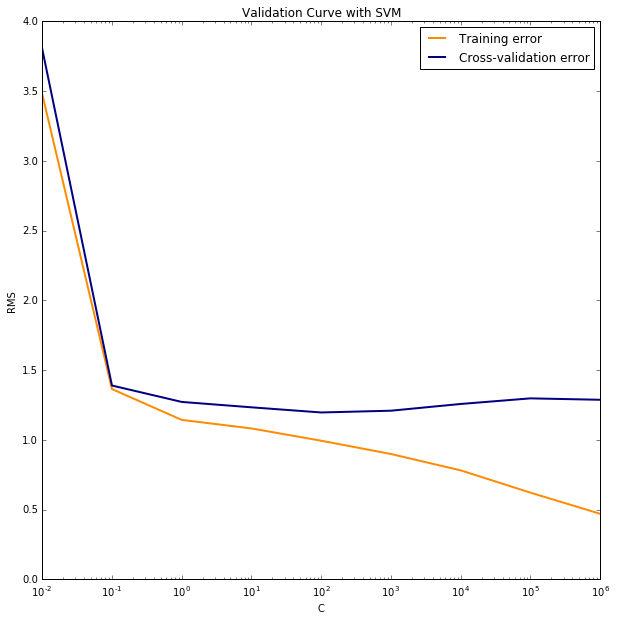

In [21]:
plt.figure(figsize=(10,10))

plt.title("Validation Curve with SVM")
plt.xlabel("C")
plt.ylabel("RMS")
#plt.ylim(0.2, 1)
lw = 2

plt.semilogx(parm_range1, train_scores_mean1, label="Training error", color="darkorange", lw=lw)
plt.semilogx(parm_range1, test_scores_mean1, label="Cross-validation error", color="navy", lw=lw)

plt.legend(loc="best")
#plt.gca().invert_xaxis()
plt.show()

### Confusion matrix and average test F1 score

Let's see how we do with predicting the actual facies, by looking at a confusion matrix. We do this by keeping the parameters from the previous section, but creating a brand new classifier. So when we fit the data, it won't have seen it before.

In [22]:
from sklearn import svm
SVC_classifier_conf = svm.SVC(C = 100, cache_size=2400, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=False)

In [23]:
SVC_classifier_conf.fit(X,y)
svc_pred = SVC_classifier_conf.predict(X)

from sklearn.metrics import confusion_matrix
from classification_utilities import display_cm, display_adj_cm

conf = confusion_matrix(svc_pred, y)
display_cm(conf, facies_labels, display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS   167    44    10                                       221
     CSiS    88   546   128     1     7           1     5         776
     FSiS     4   145   466     4     5     2           5         631
     SiSh                 4   118    19    32     1    12     1   187
       MS                 1     7    72    22     3    16     2   123
       WS           2     3    45    78   317     8   103     7   563
        D                       1     1     5    71     6     4    88
       PS           1     3     8    34    81    12   332    15   486
       BS                             1     3     2    19   132   157

Precision  0.64  0.74  0.76  0.64  0.33  0.69  0.72  0.67  0.82  0.70
   Recall  0.76  0.70  0.74  0.63  0.59  0.56  0.81  0.68  0.84  0.69
       F1  0.70  0.72  0.75  0.64  0.42  0.62  0.76  0.67  0.83  0.69


In [24]:
f1_SVC = []

for train, test in logo.split(X, y, groups=wells):
    well_name = wells[test[0]]
    SVC_classifier_conf.fit(X[train], y[train])
    pred = SVC_classifier_conf.predict(X[test])
    sc = f1_score(y[test], pred, labels = np.arange(10), average = 'micro')
    print("{:>20s}  {:.3f}".format(well_name, sc))
    f1_SVC.append(sc)
    
print "-Average leave-one-well-out F1 Score: %6f" % (sum(f1_SVC)/(1.0*(len(f1_SVC))))

     CHURCHMAN BIBLE  0.542
      CROSS H CATTLE  0.347
            LUKE G U  0.440
               NEWBY  0.400
               NOLAN  0.494
          Recruit F9  0.721
             SHANKLE  0.483
           SHRIMPLIN  0.590
-Average leave-one-well-out F1 Score: 0.502174


### Predicting, displaying, and saving facies for blind wells

For the plot we will use a function from the original notebook.

In [25]:
blind = pd.read_csv('validation_data_nofacies.csv') 
X_blind = np.array(blind.drop(['Formation', 'Well Name'], axis=1)) 
X_blind = scaler.transform(X_blind) 
y_pred = SVC_classifier_conf.fit(X, y).predict(X_blind) 
blind['Facies'] = y_pred

In [26]:
def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

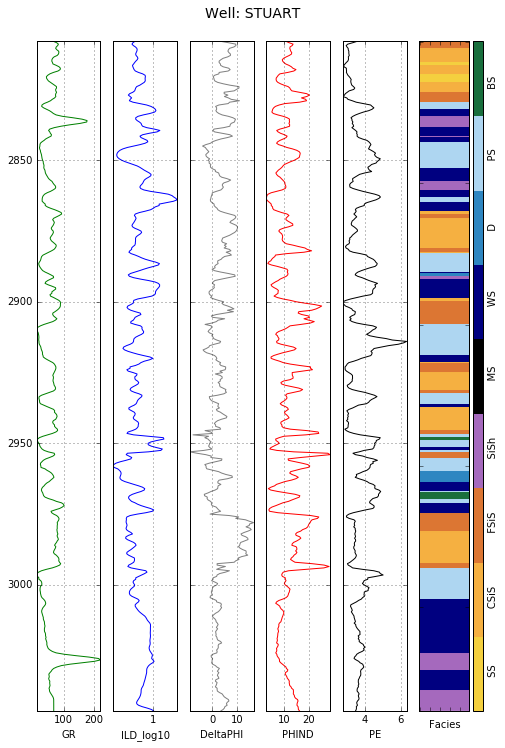

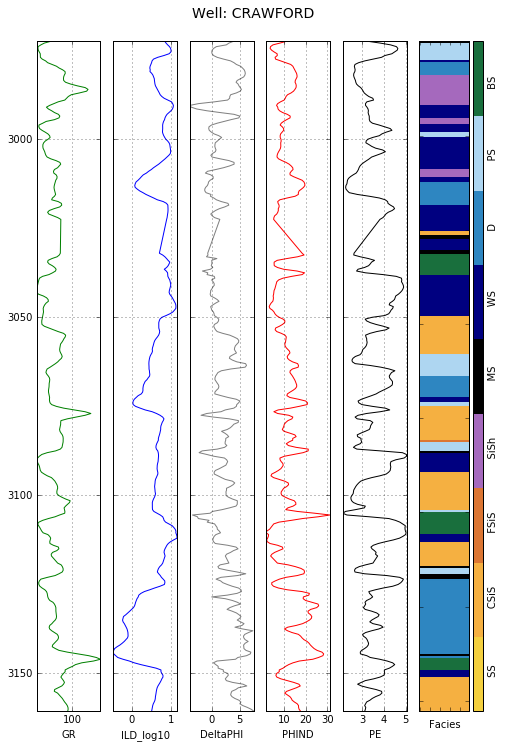

In [27]:
make_facies_log_plot(blind[blind['Well Name'] == 'STUART'], facies_colors)
make_facies_log_plot(blind[blind['Well Name'] == 'CRAWFORD'], facies_colors)

In [28]:
np.save('ypred.npy', y_pred)

### Displaying predicted versus original facies in the training data

This is a nice display to finish up with, as it gives us a visual idea of the predicted faces where we have facies from the core observations.
The plot we will use a function from the original notebook. Let's look at the well with the lowest F1 from the previous code block, CROSS H CATTLE, and the one with the highest F1 (excluding Recruit F9), which is SHRIMPLIN.

In [29]:
def compare_facies_plot(logs, compadre, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster1 = np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs[compadre].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(9, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im1 = ax[5].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    im2 = ax[6].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[6])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im2, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    ax[6].set_xlabel(compadre)
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    ax[6].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

In [30]:
SVC_classifier_conf.fit(X,y)
pred = SVC_classifier_conf.predict(X)

X = training_data
X['Prediction'] = pred

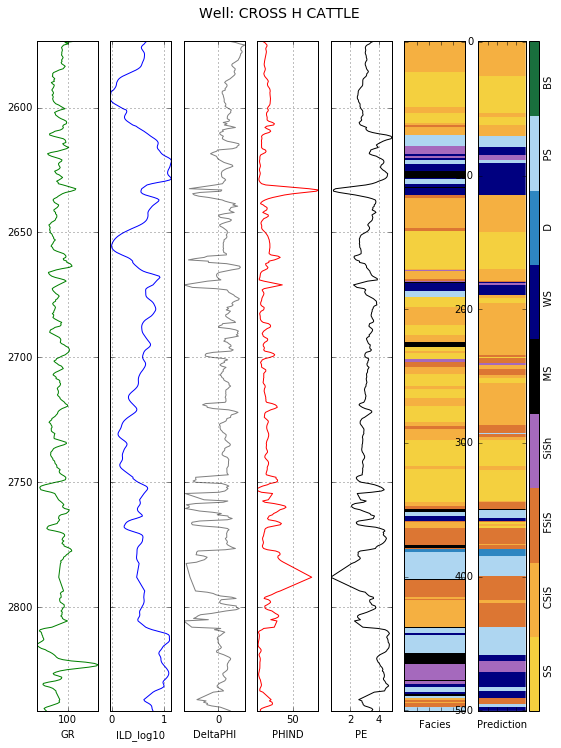

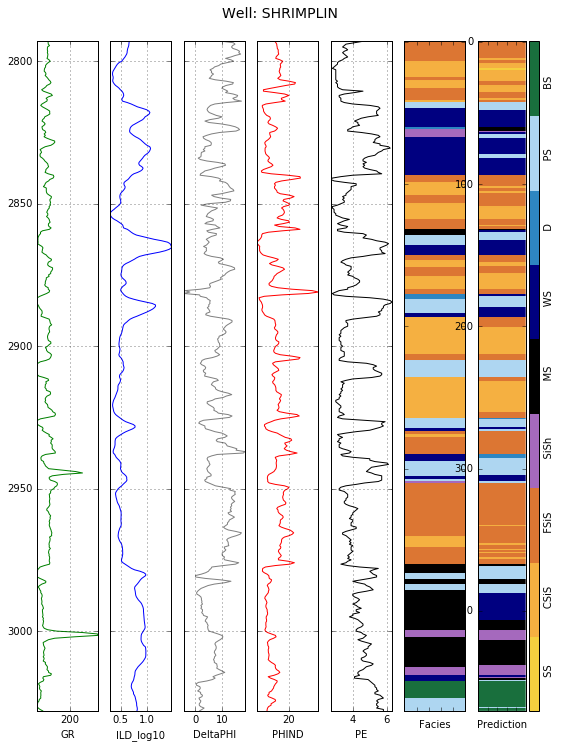

In [31]:
compare_facies_plot(X[X['Well Name'] == 'CROSS H CATTLE'], 'Prediction', facies_colors)
compare_facies_plot(X[X['Well Name'] == 'SHRIMPLIN'], 'Prediction', facies_colors)